In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth
100%|██████████| 340M/340M [00:07<00:00, 48.9MB/s]
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_384.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_384.pt
100%|██████████| 403M/403M [00:02<00:00, 189MB/s]


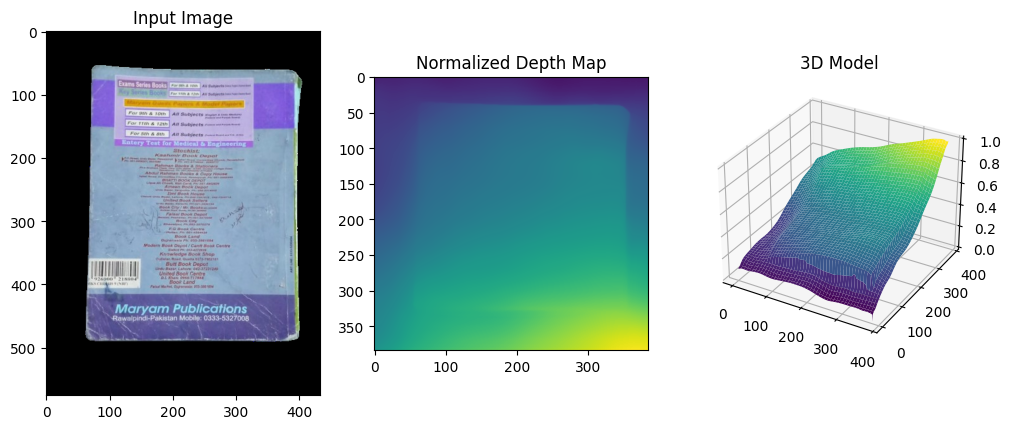

Estimated Dimensions (X, Y) for /content/drive/MyDrive/nust_ml_task/book1.png: 0.11191777139902115, 0.5135948061943054
Accuracy for /content/drive/MyDrive/nust_ml_task/book1.png: 0.17871787931238448%


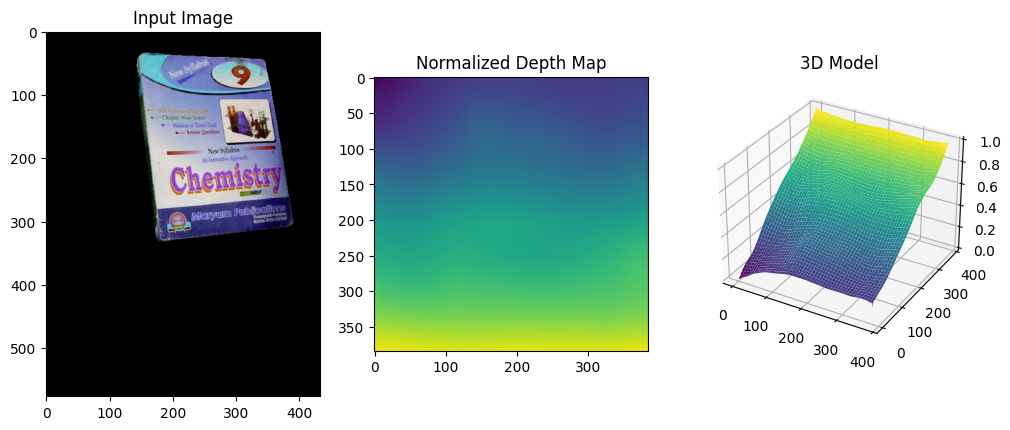

Estimated Dimensions (X, Y) for /content/drive/MyDrive/nust_ml_task/book2.png: 0.19030745327472687, 1.0
Accuracy for /content/drive/MyDrive/nust_ml_task/book2.png: 0.3400878437927801%


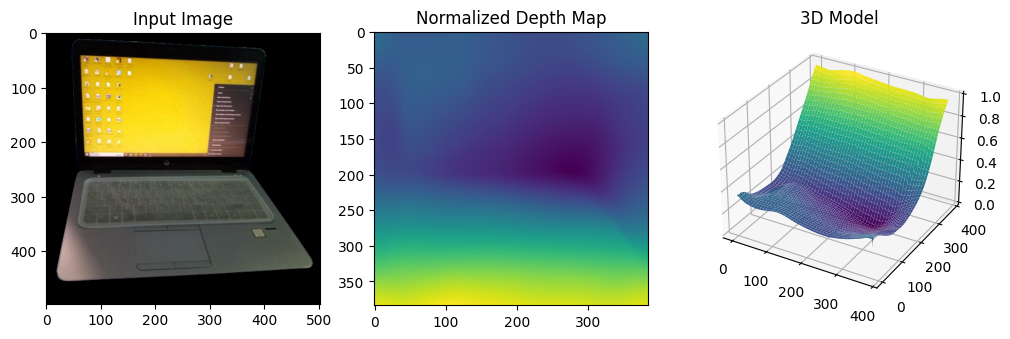

Estimated Dimensions (X, Y) for /content/drive/MyDrive/nust_ml_task/laptop.png: 0.3582487106323242, 0.9701034426689148
Accuracy for /content/drive/MyDrive/nust_ml_task/laptop.png: 0.37952918665750124%


In [4]:
from google.colab.patches import cv2_imshow
import torch
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

def load_midas_model():
    # Load the pre-trained MiDaS model
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")

    # Set the model to evaluation mode
    midas.eval()
    return midas

def preprocess_image(image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the input image to match the expected input size of the MiDaS model
    img = cv2.resize(img, (384, 384))

    img_tensor = F.to_tensor(img).unsqueeze(0)
    return img_tensor

def depth_estimation(image_tensor, midas_model):
    # Perform depth estimation
    with torch.no_grad():
        prediction = midas_model(image_tensor)

    # Convert the depth map to a numpy array
    depth_map = prediction.squeeze().cpu().numpy()
    return depth_map

def visualize_depth(image, depth_map):
    # Normalize the depth map for visualization
    normalized_depth = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

    # Visualize the input image and depth map
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(normalized_depth, cmap='viridis')
    plt.title("Normalized Depth Map")

    # Create a 3D plot
    ax = plt.subplot(1, 3, 3, projection='3d')
    x, y = np.meshgrid(range(normalized_depth.shape[1]), range(normalized_depth.shape[0]))
    ax.plot_surface(x, y, normalized_depth, cmap='viridis')
    ax.set_title("3D Model")

    # Display the plots
    plt.show()

    return normalized_depth

def calculate_dimensions(depth_map):
    # Assume pixel size in real-world units (e.g., millimeters)
    pixel_size = 1.0

    # Calculate dimensions based on the depth map
    x_size = np.max(depth_map, axis=1) * pixel_size
    y_size = np.max(depth_map, axis=0) * pixel_size

    return x_size[0], y_size[0]  # Take the first element of each array

def calculate_accuracy(reference_dimensions, estimated_dimensions):
    # Calculate accuracy as the percentage difference
    accuracy = 100 * (1 - np.sum(np.abs(reference_dimensions - estimated_dimensions)) / np.sum(reference_dimensions))
    return accuracy

if __name__ == "__main__":
    # Load MiDaS model
    midas_model = load_midas_model()

    # Specify the paths to multiple input images
    image_paths = [
        "/content/drive/MyDrive/nust_ml_task/book1.png",
        "/content/drive/MyDrive/nust_ml_task/book2.png",
        '/content/drive/MyDrive/nust_ml_task/laptop.png'
        # Add more image paths as needed
    ]

    for image_path in image_paths:
        # Preprocess the input image
        input_image = preprocess_image(image_path)

        # Perform depth estimation
        depth_map = depth_estimation(input_image, midas_model)

        # Visualize the input image, depth map, and 3D model
        image = cv2.imread(image_path)
        normalized_depth = visualize_depth(image, depth_map)

        # Calculate dimensions based on the depth map
        x_size, y_size = calculate_dimensions(normalized_depth)
        print(f"Estimated Dimensions (X, Y) for {image_path}: {x_size}, {y_size}")

        # Assuming you have reference dimensions, e.g., from a ground truth
        reference_dimensions = np.array([150.0, 200.0])  # Adjust these values based on your reference

        # Calculate accuracy
        accuracy = calculate_accuracy(reference_dimensions, np.array([x_size, y_size]))
        print(f"Accuracy for {image_path}: {accuracy}%")


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from google.colab.patches import cv2_imshow
import torch
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

def load_midas_model():
    # Load the pre-trained MiDaS model
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")

    # Set the model to evaluation mode
    midas.eval()
    return midas

def preprocess_image(image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the input image to match the expected input size of the MiDaS model
    img = cv2.resize(img, (384, 384))

    img_tensor = F.to_tensor(img).unsqueeze(0)
    return img_tensor

def depth_estimation(image_tensor, midas_model):
    # Perform depth estimation
    with torch.no_grad():
        prediction = midas_model(image_tensor)

    # Convert the depth map to a numpy array
    depth_map = prediction.squeeze().cpu().numpy()
    return depth_map

def visualize_depth(image, depth_map):
    # Normalize the depth map for visualization
    normalized_depth = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

    # Visualize the input image and depth map
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(normalized_depth, cmap='viridis')
    plt.title("Normalized Depth Map")

    # Create a 3D plot
    ax = plt.subplot(1, 3, 3, projection='3d')
    x, y = np.meshgrid(range(normalized_depth.shape[1]), range(normalized_depth.shape[0]))
    ax.plot_surface(x, y, normalized_depth, cmap='viridis')
    ax.set_title("3D Model")

    # Display the plots
    plt.show()

    return normalized_depth

def calculate_dimensions(depth_map):
    # Assume pixel size in real-world units (e.g., millimeters)
    pixel_size = 1.0

    # Calculate dimensions based on the depth map
    x_size = np.max(depth_map, axis=1) * pixel_size
    y_size = np.max(depth_map, axis=0) * pixel_size

    return x_size[0], y_size[0]  # Take the first element of each array

def calculate_accuracy(reference_dimensions, estimated_dimensions):
    # Calculate accuracy as the percentage difference
    accuracy = 100 * (1 - np.sum(np.abs(reference_dimensions - estimated_dimensions)) / np.sum(reference_dimensions))
    return accuracy
def fine_tune_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()
    torch.cuda.empty_cache()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to the appropriate device (e.g., GPU if available)


    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for inputs, targets in train_loader:
        # inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Print average loss for the epoch
        average_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

    return model

if __name__ == "__main__":
    # Load MiDaS model
    midas_model = load_midas_model()
    train_data = TensorDataset(torch.randn((100, 3, 384, 384)), torch.randn((100, 1, 384, 384)))
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Fine-tune the model
    fine_tuned_model = fine_tune_model(midas_model, train_loader)

    # Specify the paths to multiple input images
    image_paths = [
        "/content/drive/MyDrive/ml_task/laptop.png",
        "/content/drive/MyDrive/ml_task/book.png",
        # Add more image paths as needed
    ]

    for image_path in image_paths:
        # Preprocess the input image
        input_image = preprocess_image(image_path)

        # Perform depth estimation
        depth_map = depth_estimation(input_image, midas_model)

        # Visualize the input image, depth map, and 3D model
        image = cv2.imread(image_path)
        normalized_depth = visualize_depth(image, depth_map)

        # Calculate dimensions based on the depth map
        x_size, y_size = calculate_dimensions(normalized_depth)
        print(f"Estimated Dimensions (X, Y) for {image_path}: {x_size}, {y_size}")

        # Assuming you have reference dimensions, e.g., from a ground truth
        reference_dimensions = np.array([150.0, 200.0])  # Adjust these values based on your reference

        # Calculate accuracy
        accuracy = calculate_accuracy(reference_dimensions, np.array([x_size, y_size]))
        print(f"Accuracy for {image_path}: {accuracy}%")


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


Loading weights:  None
